# Predictive model for health and safety inspections.

# Training and testing

## Note: remember to start postgresql server!

In [1]:
## Python packages
import random
import time
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from class_imb import downsample
from osha import sic_division, fopi

In [2]:
# Database name and username
dbname = 'osha_db'
username = 'asc'

# Connection to SQL database
conn = None
conn = psycopg2.connect(database = dbname, user = username)

## Query relevant data for model from database

In [3]:
# date, ownership, num. workers, union, SIC, state, target
usa_6plus1_query = '''
SELECT 
open_date, owner_type, nr_in_estab, union_status, sic_code, site_state, is_violation
FROM inspections_table;
'''

In [4]:
# Query from database
sql_query = usa_6plus1_query

my_data = pd.read_sql_query(sql_query, conn)
#my_data.columns

In [5]:
from osha import fopi
print "Violation fraction over entire dataset:", fopi(my_data, 'is_violation')

Violation fraction over entire dataset: 0.255160867857


# Data transformations

In [6]:
# Missing values

# Fill NaN with zeroes or drop in number of employees

method="drop" #"fill"

if(method=="fill"):
    my_data['nr_in_estab'].fillna(0, inplace=True)
elif(method=="drop"):
    my_data.dropna(axis=0, inplace=True)
elif(method=="median"):
    my_data['nr_in_estab'].fillna(my_data['nr_in_estab'].median(), inplace=True)

In [7]:
print "Violation fraction over entire dataset:", fopi(my_data, 'is_violation')

Violation fraction over entire dataset: 0.291847348591


In [8]:
# Aggregate SIC numbers by division
from osha import sic_division
my_data['sic_code'] = my_data['sic_code'].apply(sic_division)

In [9]:
# Select data from 1996-2015

start_date = '1996-1-1'
end_date   = '2016-1-1'

# Dataframe must be Series with dtype datetime64[ns]
my_data['open_date'] = pd.to_datetime(my_data['open_date'])  
mask = (my_data['open_date'] > start_date) & (my_data['open_date'] <= end_date)
my_data = my_data.loc[mask]

In [10]:
print "Violation fraction for years 1996-2015:", fopi(my_data, 'is_violation')

Violation fraction for years 1996-2015: 0.353422242022


In [11]:
# Now discard date column
XY = my_data.drop('open_date', axis=1)

In [12]:
# Create dummies for all categorical variables
XY = pd.get_dummies(XY, columns=[
    'sic_code', 
    'owner_type', 
    'union_status',
    'site_state',
    ])

In [14]:
# Downsample data
from class_imb import downsample

XY = downsample(XY, 'is_violation')

### Split into train and test sets for later use

In [17]:
print "Violation fraction after downsampling:", fopi(XY, 'is_violation')

 Violation fraction after downsampling: 0.5


In [18]:
from sklearn.model_selection import train_test_split

test_fraction = 0.20

X = XY.drop('is_violation', axis=1)
Y = XY['is_violation']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, 
    test_size=test_fraction, 
    random_state=np.random.seed(int(time.time())))

p1_train = float(sum(y_train))/y_train.shape[0] 
p1_test = float(sum(y_test))/y_test.shape[0]
print "Proportions of class 1"
print "   Training data: ", p1_train
print "   Test data:     ", p1_test

Proportions of class 1
   Training data:  0.500074245327
   Test data:      0.499703019304


# Hyperparameter search

In [19]:
# Utility function to report best scores of random search of hyperparameters


from time import time

def print_RSCV_results(results, n_top=3):
    '''
    Print results of Randomized Search CV
    
    INPUT
      - results : results object of RandomizedSearchCV
      - n_top   : number of models to display, from highest to lowest metric
    
    OUTPUT
      - none
    '''
    
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print "Model with rank: {0}".format(i)
            print "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate])
            print "Parameters: {0}".format(results['params'][candidate])
            print ""# specify parameters and distributions to sample from
        

In [20]:
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [22]:
# Initialize classifier instance
clf = RandomForestClassifier()
        
# Dictionary containing hyperparameter values.
# Keys coincide with RF variable names
param_dist = {"max_features": sp_randint(int(np.sqrt(X.shape[1]))/2, 2*np.sqrt(X.shape[1])),  
             "min_samples_split": sp_randint(2, 10),
             "min_samples_leaf": sp_randint(1, 5),
             "criterion": ["gini", "entropy"],
             "n_estimators": range(int(np.sqrt(X.shape[1])), X.shape[1]/3)} 
                # run randomized search

n_iter_search = 5 # number of parameter choices
random_search = RandomizedSearchCV(
    clf, 
    param_distributions=param_dist,
    scoring="accuracy",
    n_iter=n_iter_search,
    cv=8,
    n_jobs=2,
    verbose=2)


# X_train, X_test, y_train, y_test
start = time()
random_search.fit(X_train, y_train)
#print "RandomizedSearchCV took %.2f seconds for %d candidates", " parameter settings." % ((time() - start), n_iter_search)
print "Elapsed time: ", (time() - start), "seconds for ", n_iter_search ,"hyperparameter choices"

Fitting 8 folds for each of 5 candidates, totalling 40 fits
[CV] max_features=4, min_samples_split=8, criterion=gini, n_estimators=10, min_samples_leaf=3 
[CV] max_features=4, min_samples_split=8, criterion=gini, n_estimators=10, min_samples_leaf=3 
[CV]  max_features=4, min_samples_split=8, criterion=gini, n_estimators=10, min_samples_leaf=3, total= 1.4min
[CV] max_features=4, min_samples_split=8, criterion=gini, n_estimators=10, min_samples_leaf=3 
[CV]  max_features=4, min_samples_split=8, criterion=gini, n_estimators=10, min_samples_leaf=3, total= 1.5min
[CV] max_features=4, min_samples_split=8, criterion=gini, n_estimators=10, min_samples_leaf=3 
[CV]  max_features=4, min_samples_split=8, criterion=gini, n_estimators=10, min_samples_leaf=3, total= 1.5min
[CV] max_features=4, min_samples_split=8, criterion=gini, n_estimators=10, min_samples_leaf=3 
[CV]  max_features=4, min_samples_split=8, criterion=gini, n_estimators=10, min_samples_leaf=3, total= 1.6min
[CV] max_features=4, min_

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 43.5min


[CV] max_features=6, min_samples_split=5, criterion=entropy, n_estimators=16, min_samples_leaf=3 
[CV]  max_features=6, min_samples_split=5, criterion=entropy, n_estimators=16, min_samples_leaf=3, total= 3.2min
[CV] max_features=6, min_samples_split=5, criterion=entropy, n_estimators=16, min_samples_leaf=3 
[CV]  max_features=6, min_samples_split=5, criterion=entropy, n_estimators=16, min_samples_leaf=3, total= 3.0min
[CV]  max_features=6, min_samples_split=5, criterion=entropy, n_estimators=16, min_samples_leaf=3, total= 3.1min


[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed: 46.9min finished


Elapsed time:  2964.98273611 seconds for  5 hyperparameter choices


In [23]:
print_RSCV_results(random_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.655 (std: 0.001)
Parameters: {'max_features': 12, 'min_samples_split': 7, 'min_samples_leaf': 4, 'criterion': 'entropy', 'n_estimators': 10}

Model with rank: 2
Mean validation score: 0.654 (std: 0.001)
Parameters: {'max_features': 6, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'entropy', 'n_estimators': 16}

Model with rank: 3
Mean validation score: 0.653 (std: 0.002)
Parameters: {'max_features': 4, 'min_samples_split': 8, 'min_samples_leaf': 3, 'criterion': 'gini', 'n_estimators': 10}



### Assessing model metrics for optimal hyperparameters

#### Train model

In [24]:
# Retrain model with optimal parameters on all of the train data.
from sklearn.ensemble import RandomForestClassifier


# Optimal parameter values
optparams = random_search.cv_results_['params'][np.argmin(random_search.cv_results_['rank_test_score'])]


clf = RandomForestClassifier(n_jobs=2, n_estimators=30,
    min_samples_leaf  = optparams['min_samples_leaf'],
    min_samples_split = optparams['min_samples_split'], 
    criterion         = optparams['criterion'], 
    max_features      = optparams['max_features']
    ) #, random_state=0)


clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=12, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=4,
            min_samples_split=7, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

#### Compute metrics for model on test data

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score

y_pred = clf.predict(X_test)

apr = [
    accuracy_score(y_test, y_pred), 
    precision_score(y_test, y_pred), 
    recall_score(y_test, y_pred)]  


print "  accuracy:  ", apr[0] # can also be computed with clf.score(X_test, y_test)
print "  precision: ", apr[1]
print "  recall:    ", apr[2]

# ROC (receiver operating characteristic) AUC (area under the curve) is insensitive of unbalanced classes
auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print "  AUC:       ", auc

  accuracy:   0.656925424847
  precision:  0.650327392499
  recall:     0.677988906131
  AUC:        0.7062850416


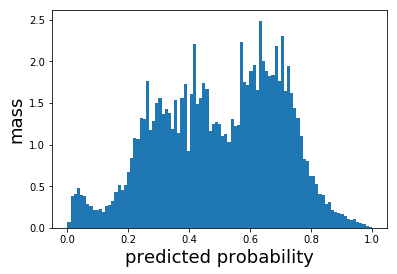

In [26]:
# Probabilities of positive class
pred_prob = clf.predict_proba(X_test)[:,1]
height, edges, patches = plt.hist(pred_prob, bins='auto', normed='true')

fs = 18

plt.xlabel('predicted probability', fontsize=fs)
plt.ylabel('mass', fontsize=fs)

In [28]:
# What's the integral of the probability density of p_1 at 
# the decision threshold of 0.5?
prob_int = (edges[1:] - edges[:-1])*height
prob_int = sum(prob_int[0:len(prob_int)/2])
print "Integrated probability up to decision threshold = ", prob_int

Integrated probability up to decision threshold =  0.474290546115


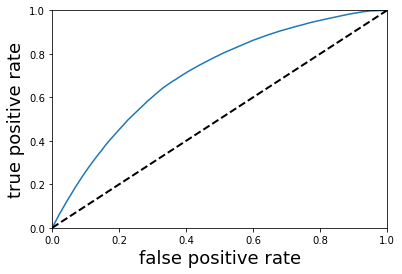

In [29]:
# ROC curve
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)#, pos_label=2)

# 
lw = 2
fs = 18
plt.plot(fpr, tpr)#, label='RT + LR')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('false positive rate', fontsize=fs )
plt.ylabel('true positive rate', fontsize=fs )
#plt.title('receiver operating characteristic')
plt.xlim(0,1)
plt.ylim(0,1)
plt.savefig('usa1996-2015_roc_curve.png',  bbox_inches='tight')

In [30]:
# Compute feature importance
feat_imp = clf.feature_importances_
num_feat = len(feat_imp)

# Sort in ascending order
index_sorted = np.flip(np.argsort(feat_imp), 0)
feat_imp = feat_imp[index_sorted]
feature_labels = X_test.columns[index_sorted]

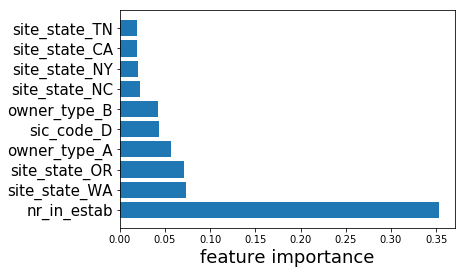

In [31]:
# Plot feature importance

fs=18

Nbars= 10# np.shape(clf.feature_importances_)[0]

fig, ax = plt.subplots()


ax.barh(np.arange(0,Nbars), feat_imp[0:Nbars])
ax.set_yticks(np.arange(0,Nbars))

ax.set_yticklabels(feature_labels, fontsize=fs-3) #, rotation='vertical')

ax.set_xlabel('feature importance', fontsize=fs)
#ax.set_title('Feature', fontsize=fs)
plt.savefig('feature_importance_all.png',  bbox_inches='tight', dpi=500)

In [32]:
# Aggregate features by type
imp = np.zeros(5)
lbls = [
    'number of workers', 
    'ind. sector', 
    'ownership type', 
    'US state',
    'union affiliation']

for i in range(0,np.shape(feat_imp)[0]):
    
    lbl=feature_labels.values[i] # These are already sorted
    
    if   lbl[0:3] == 'nr_':
        imp[0] += feat_imp[i]
    elif lbl[0:3] == 'sic':
        imp[1] += feat_imp[i]
    elif lbl[0:3] == 'own':
        imp[2] += feat_imp[i]
    elif lbl[0:3] == 'sit':
        imp[3] += feat_imp[i]
    elif lbl[0:3] == 'uni':
        imp[4] += feat_imp[i]


# Sort in ascending order
agg_index_sorted = np.flip(np.argsort(imp), 0)
agg_feat_imp = imp[agg_index_sorted]

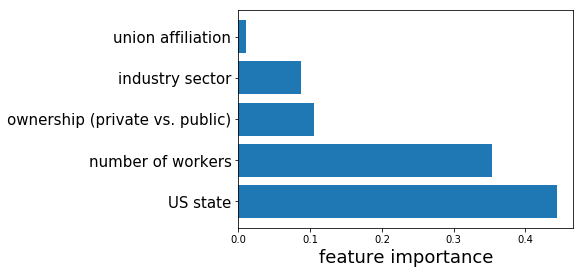

In [33]:
# Plot aggregated feature importance

fs=18

Nbars= len(imp)

fig, ax = plt.subplots()


ax.barh(np.arange(0,Nbars), imp[agg_index_sorted])
ax.set_yticks(np.arange(0,Nbars))

my_labels = ['number of workers', 
             'industry sector',
             'ownership (private vs. public)', 
             'US state', 
             'union affiliation']

ax.set_yticklabels(np.array(my_labels)[agg_index_sorted], fontsize=fs-3) #, rotation='vertical')



ax.set_xlabel('feature importance', fontsize=fs)
plt.savefig('feature_importance_grouped.png',  bbox_inches='tight', dpi=500)

#### Convergence of K-L divergence of p(p(1))
One hyperparameter that was not optimized was the number of estimators. We chose the value n_estimators=30. Is the model converged at that value or will we need more estimators?

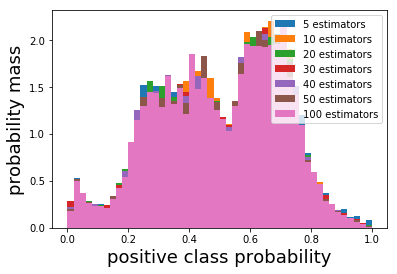

In [34]:
# Train and compute probabilities

Nbins = 50 # Bins for histograms
n_est = [5, 10, 20, 30, 40, 50, 100]

hbins=[]
for n in n_est:
    
    clf_KL = RandomForestClassifier(n_jobs=2, n_estimators = n, 
        min_samples_leaf  = optparams['min_samples_leaf'],
        min_samples_split = optparams['min_samples_split'], 
        criterion         = optparams['criterion'], 
        max_features      = optparams['max_features'], 
        )

    clf_KL.fit(X_train, y_train)
    
    
    pred_prob = clf_KL.predict_proba(X_test)[:,1]
    h, e, p = plt.hist(
        pred_prob, 
        bins=Nbins, 
        range=(0.0,1.0), 
        normed='true',
        label=str(n)+ ' estimators')

    
    hbins.append(h)

plt.xlabel('positive class probability', fontsize=fs)
plt.ylabel('probability mass', fontsize=fs)
plt.legend()
#plt.savefig('./p1dist_nestimators.png')

In [35]:
# Kullbeck-Leibler divergence
def KL_div(p1, p2, threshold = 1.0E-07):
    '''
    Kullbeck-Leibler divervgence of distribution
    p1 to p2.
    '''
    p1 = np.asarray(p1, dtype=np.float)
    p2 = np.asarray(p2, dtype=np.float)
    
        
    # If there are zeros, remove.
    # Remove first zeros from p1
    p2 = np.extract(p1 > threshold, p2)
    p1 = np.extract(p1 > threshold, p1)
    
    # Now remove zeros from p2
    p1 = np.extract(p2 > threshold, p1)
    p2 = np.extract(p2 > threshold, p2)
        
    return np.sum(p1 * np.log(p1 / p2))
    

In [36]:
# From probabilities, compute KL divergences
# to the baseline (larger n_estiamators model)
KLs=np.zeros(len(hbins)-1)

for i in range(0,len(hbins)-1):
    p = hbins[i]
    q = hbins[len(hbins)-1]
    KLs[i] = KL_div(p,q)
    

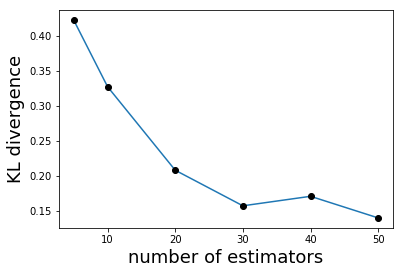

In [37]:
# Plot KL divergences
fs=18

plt.plot(n_est[0:len(hbins)-1], KLs, '-')
plt.plot(n_est[0:len(hbins)-1], KLs, 'o', color='k', markersize=6)
plt.xlabel('number of estimators', fontsize=fs)
plt.ylabel('KL divergence', fontsize=fs)
plt.savefig('./KLdivergence_Nestimators.png',  bbox_inches='tight', dpi=500)

*We observe that at n_estimators=30 the probability distribution relative to the baseline is well converged.*

*Let us measure now the convergence of the model with respect to the number of data points in the set by means of a learning curve*

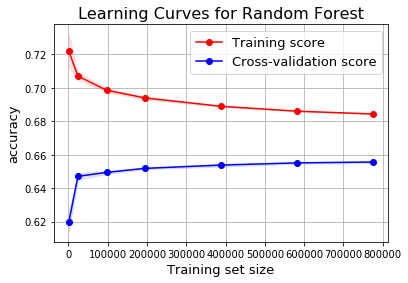

In [49]:
# Is the model well converged relative to the number of data points?
# Let's generate the learning curve. Code adapted from sklearn's documentation:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
import time
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5), scorer='accuracy', n_jobs=1, fontsize=15):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.
        
    scoring : sklearn's scorer object label, optional
        Scoring metric for learning curve (default 'accuracy')
    
    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    
    fontsize: size of font for title. Axis labels and legend have a size of 3 units less.
    
    
    """
    plt.figure()
    plt.title(title, fontsize=fontsize)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training set size", fontsize=fontsize-3)
    plt.ylabel(scorer, fontsize=fontsize-3)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best", fontsize=fontsize-3)
    return plt



title = "Learning Curves for Random Forest"
# Cross validation with 25 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=int(time.time()))

# Choose training sizes
ts = (0.001, 0.025, 0.1, 0.2, 0.4, 0.6, 0.8)

plot_learning_curve(clf, title, X, Y, cv=cv, train_sizes=ts , n_jobs=2, fontsize=16)
plt.savefig('./learning_curve.png', bbox_inches='tight', dpi=500);

In [51]:
# Refit with all the data and save the model to disk 
import pickle

clf.fit(X,Y)
filename = './trained_RF.sav'
pickle.dump(clf, open(filename, 'wb'))

In [52]:
# Create an empty dataframe with only one 
# row for website. Save then as CSV
empty_df = pd.DataFrame(0, index=np.arange(0,1), columns=XY.columns.values)
empty_df = empty_df.drop('is_violation', axis=1)
empty_df.to_csv('./empty_df_all_features.csv')